# Changes from v1: 
#####  1. Switched to LeakyReLU (from ReLU) on generator. 

In [1]:
import os

DATA_DIR = 'C:/Users/yigii/OneDrive/Masaüstü/python_projects/portfolioprojects/gan/animefaces/animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [2]:
print(os.listdir(DATA_DIR+'/images')[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import numpy as np

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

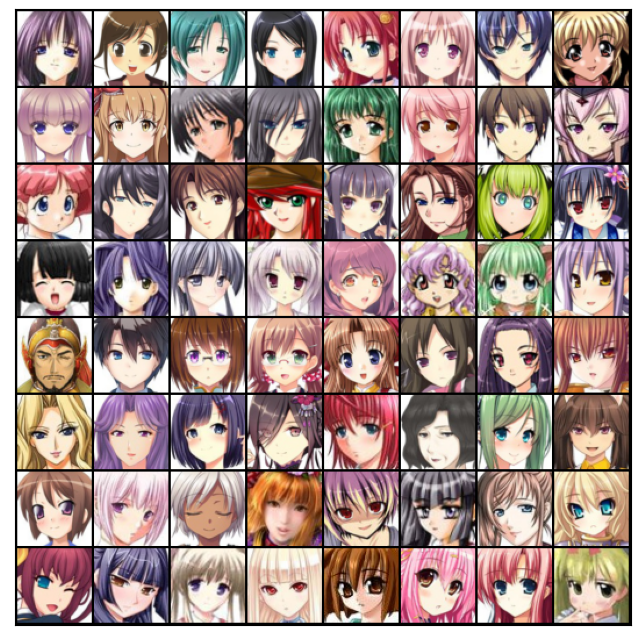

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


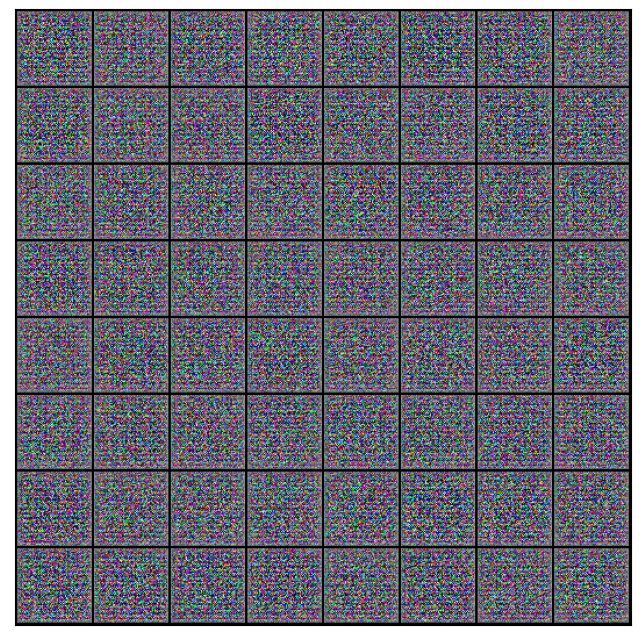

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


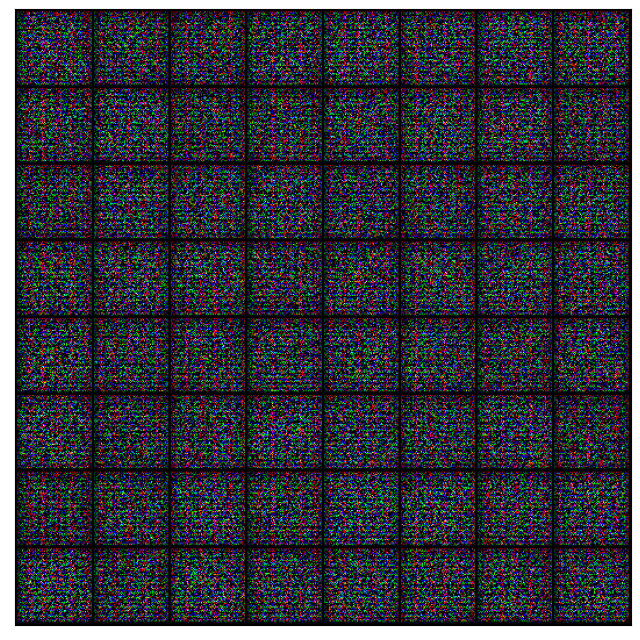

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
def fit(epochs, lr, start_idx=1, losses_g=[], losses_d=[], real_scores=[], fake_scores=[]):
    torch.cuda.empty_cache()
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        
        batch_losses_d, batch_losses_g, batch_real_scores, batch_fake_scores= [], [], [], []        
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
           
            # Train generator
            loss_g = train_generator(opt_g)
       
            batch_losses_g.append(loss_g)
            batch_losses_d.append(loss_d)
            batch_real_scores.append(real_score)
            batch_fake_scores.append(fake_score)
        

        # Record losses & scores
        losses_g.extend(batch_losses_g)
        losses_d.extend(batch_losses_d)
        
        real_scores.extend(batch_real_scores)
        fake_scores.extend(batch_fake_scores)

        
        # Calculate epoch scores
        epoch_loss_g = np.mean(losses_g[-len(batch_losses_g):])
        epoch_loss_d = np.mean(losses_d[-len(batch_losses_d):])

        
        epoch_real_score = np.mean(real_scores[-len(batch_real_scores):])
        epoch_fake_score = np.mean(fake_scores[-len(batch_fake_scores):])

        
        # Log losses & scores (last batch)
        print(f"Epoch [{ epoch+1}/{epochs}]")
        print(f'Loss_D: {epoch_loss_d:.3f}, Loss_G: {epoch_loss_g:.3f}')
        print(f'Real_Score: {real_score:.3f}, Fake_Score: {fake_score:.3f}') 
        # Save generated images
        if (epoch+start_idx) % 10 == 0:
            save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.0002
epochs = 100

In [29]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/100]
Loss_D: 0.626, Loss_G: 5.263
Real_Score: 0.713, Fake_Score: 0.117


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/100]
Loss_D: 0.591, Loss_G: 3.964
Real_Score: 0.942, Fake_Score: 0.217


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/100]
Loss_D: 0.464, Loss_G: 4.351
Real_Score: 0.981, Fake_Score: 0.385


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/100]
Loss_D: 0.463, Loss_G: 4.641
Real_Score: 0.890, Fake_Score: 0.173


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/100]
Loss_D: 0.428, Loss_G: 4.394
Real_Score: 0.979, Fake_Score: 0.461


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/100]
Loss_D: 0.413, Loss_G: 4.433
Real_Score: 0.943, Fake_Score: 0.169


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/100]
Loss_D: 0.390, Loss_G: 4.464
Real_Score: 0.937, Fake_Score: 0.080


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/100]
Loss_D: 0.346, Loss_G: 4.584
Real_Score: 0.941, Fake_Score: 0.060


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/100]
Loss_D: 0.331, Loss_G: 4.686
Real_Score: 0.959, Fake_Score: 0.058


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/100]
Loss_D: 0.316, Loss_G: 4.659
Real_Score: 0.923, Fake_Score: 0.047
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/100]
Loss_D: 0.271, Loss_G: 4.763
Real_Score: 0.866, Fake_Score: 0.054


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/100]
Loss_D: 0.302, Loss_G: 4.774
Real_Score: 0.966, Fake_Score: 0.036


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/100]
Loss_D: 0.262, Loss_G: 4.739
Real_Score: 0.915, Fake_Score: 0.027


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/100]
Loss_D: 0.291, Loss_G: 5.025
Real_Score: 0.600, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/100]
Loss_D: 0.255, Loss_G: 4.980
Real_Score: 0.986, Fake_Score: 0.133


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/100]
Loss_D: 0.220, Loss_G: 4.989
Real_Score: 0.988, Fake_Score: 0.070


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/100]
Loss_D: 0.214, Loss_G: 5.248
Real_Score: 0.938, Fake_Score: 0.014


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/100]
Loss_D: 0.248, Loss_G: 5.199
Real_Score: 0.969, Fake_Score: 0.022


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/100]
Loss_D: 0.293, Loss_G: 4.858
Real_Score: 0.968, Fake_Score: 0.054


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/100]
Loss_D: 0.245, Loss_G: 5.008
Real_Score: 0.958, Fake_Score: 0.040
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/100]
Loss_D: 0.225, Loss_G: 5.029
Real_Score: 0.980, Fake_Score: 0.069


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/100]
Loss_D: 0.199, Loss_G: 5.364
Real_Score: 0.968, Fake_Score: 0.115


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/100]
Loss_D: 0.237, Loss_G: 5.281
Real_Score: 0.889, Fake_Score: 0.033


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/100]
Loss_D: 0.162, Loss_G: 5.329
Real_Score: 0.984, Fake_Score: 0.026


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/100]
Loss_D: 0.186, Loss_G: 5.585
Real_Score: 0.997, Fake_Score: 0.046


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/100]
Loss_D: 0.255, Loss_G: 5.548
Real_Score: 0.977, Fake_Score: 0.084


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/100]
Loss_D: 0.182, Loss_G: 5.617
Real_Score: 0.958, Fake_Score: 0.060


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/100]
Loss_D: 0.195, Loss_G: 5.570
Real_Score: 0.925, Fake_Score: 0.077


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/100]
Loss_D: 0.145, Loss_G: 5.579
Real_Score: 0.944, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/100]
Loss_D: 0.224, Loss_G: 5.845
Real_Score: 0.969, Fake_Score: 0.027
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/100]
Loss_D: 0.139, Loss_G: 5.918
Real_Score: 0.972, Fake_Score: 0.036


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/100]
Loss_D: 0.085, Loss_G: 6.392
Real_Score: 0.938, Fake_Score: 0.004


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/100]
Loss_D: 0.127, Loss_G: 6.291
Real_Score: 0.994, Fake_Score: 0.019


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/100]
Loss_D: 0.116, Loss_G: 6.771
Real_Score: 0.996, Fake_Score: 0.007


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/100]
Loss_D: 0.137, Loss_G: 7.001
Real_Score: 0.980, Fake_Score: 0.024


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/100]
Loss_D: 0.055, Loss_G: 7.169
Real_Score: 0.966, Fake_Score: 0.004


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/100]
Loss_D: 0.046, Loss_G: 8.089
Real_Score: 0.990, Fake_Score: 0.009


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/100]
Loss_D: 0.022, Loss_G: 8.642
Real_Score: 0.941, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/100]
Loss_D: 0.121, Loss_G: 11.953
Real_Score: 0.988, Fake_Score: 0.011


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/100]
Loss_D: 0.090, Loss_G: 8.000
Real_Score: 0.969, Fake_Score: 0.014
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/100]
Loss_D: 0.060, Loss_G: 7.842
Real_Score: 0.974, Fake_Score: 0.003


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/100]
Loss_D: 0.103, Loss_G: 9.547
Real_Score: 0.995, Fake_Score: 0.010


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/100]
Loss_D: 0.063, Loss_G: 9.321
Real_Score: 1.000, Fake_Score: 0.003


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/100]
Loss_D: 0.076, Loss_G: 9.621
Real_Score: 0.993, Fake_Score: 0.003


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/100]
Loss_D: 0.089, Loss_G: 8.457
Real_Score: 0.972, Fake_Score: 0.007


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/100]
Loss_D: 0.087, Loss_G: 10.863
Real_Score: 0.936, Fake_Score: 0.001


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/100]
Loss_D: 0.056, Loss_G: 11.785
Real_Score: 1.000, Fake_Score: 0.001


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/100]
Loss_D: 0.057, Loss_G: 12.252
Real_Score: 0.995, Fake_Score: 0.011


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/100]
Loss_D: 0.106, Loss_G: 13.855
Real_Score: 1.000, Fake_Score: 0.018


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/100]
Loss_D: 0.053, Loss_G: 10.619
Real_Score: 0.999, Fake_Score: 0.003
Saving generated-images-0050.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [51/100]
Loss_D: 0.116, Loss_G: 9.505
Real_Score: 0.995, Fake_Score: 0.044


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [52/100]
Loss_D: 0.093, Loss_G: 10.394
Real_Score: 1.000, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [53/100]
Loss_D: 0.066, Loss_G: 11.772
Real_Score: 0.996, Fake_Score: 0.008


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [54/100]
Loss_D: 0.088, Loss_G: 11.888
Real_Score: 0.973, Fake_Score: 0.058


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [55/100]
Loss_D: 0.058, Loss_G: 9.843
Real_Score: 0.998, Fake_Score: 0.002


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [56/100]
Loss_D: 0.074, Loss_G: 11.700
Real_Score: 1.000, Fake_Score: 0.001


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [57/100]
Loss_D: 0.064, Loss_G: 9.382
Real_Score: 0.993, Fake_Score: 0.004


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [58/100]
Loss_D: 0.065, Loss_G: 14.013
Real_Score: 0.914, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [59/100]
Loss_D: 0.084, Loss_G: 12.983
Real_Score: 0.981, Fake_Score: 0.032


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [60/100]
Loss_D: 0.073, Loss_G: 11.627
Real_Score: 0.991, Fake_Score: 0.046
Saving generated-images-0060.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [61/100]
Loss_D: 0.036, Loss_G: 9.792
Real_Score: 0.990, Fake_Score: 0.009


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [62/100]
Loss_D: 0.201, Loss_G: 14.764
Real_Score: 0.992, Fake_Score: 0.039


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [63/100]
Loss_D: 0.058, Loss_G: 13.075
Real_Score: 0.981, Fake_Score: 0.001


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [64/100]
Loss_D: 0.111, Loss_G: 13.454
Real_Score: 0.970, Fake_Score: 0.005


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [65/100]
Loss_D: 0.084, Loss_G: 9.115
Real_Score: 0.991, Fake_Score: 0.001


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [66/100]
Loss_D: 0.056, Loss_G: 11.198
Real_Score: 0.999, Fake_Score: 0.006


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [67/100]
Loss_D: 0.252, Loss_G: 10.011
Real_Score: 0.998, Fake_Score: 0.017


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [68/100]
Loss_D: 0.032, Loss_G: 11.263
Real_Score: 0.991, Fake_Score: 0.002


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [69/100]
Loss_D: 0.089, Loss_G: 13.261
Real_Score: 0.991, Fake_Score: 0.002


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [70/100]
Loss_D: 0.047, Loss_G: 12.970
Real_Score: 0.999, Fake_Score: 0.017
Saving generated-images-0070.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [71/100]
Loss_D: 0.107, Loss_G: 13.415
Real_Score: 0.997, Fake_Score: 0.056


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [72/100]
Loss_D: 0.061, Loss_G: 10.202
Real_Score: 0.978, Fake_Score: 0.015


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [73/100]
Loss_D: 0.032, Loss_G: 12.816
Real_Score: 0.994, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [74/100]
Loss_D: 0.063, Loss_G: 14.855
Real_Score: 0.999, Fake_Score: 0.023


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [75/100]
Loss_D: 0.069, Loss_G: 16.681
Real_Score: 1.000, Fake_Score: 0.006


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [76/100]
Loss_D: 0.068, Loss_G: 13.548
Real_Score: 0.998, Fake_Score: 0.004


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [77/100]
Loss_D: 0.090, Loss_G: 15.676
Real_Score: 0.995, Fake_Score: 0.016


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [78/100]
Loss_D: 0.070, Loss_G: 9.777
Real_Score: 0.978, Fake_Score: 0.003


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [79/100]
Loss_D: 0.095, Loss_G: 11.874
Real_Score: 0.986, Fake_Score: 0.007


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [80/100]
Loss_D: 0.030, Loss_G: 9.937
Real_Score: 0.999, Fake_Score: 0.006
Saving generated-images-0080.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [81/100]
Loss_D: 0.091, Loss_G: 13.066
Real_Score: 0.997, Fake_Score: 0.038


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [82/100]
Loss_D: 0.086, Loss_G: 13.024
Real_Score: 0.994, Fake_Score: 0.015


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [83/100]
Loss_D: 0.048, Loss_G: 14.528
Real_Score: 0.985, Fake_Score: 0.004


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [84/100]
Loss_D: 0.071, Loss_G: 8.780
Real_Score: 0.994, Fake_Score: 0.013


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [85/100]
Loss_D: 0.085, Loss_G: 12.976
Real_Score: 1.000, Fake_Score: 0.006


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [86/100]
Loss_D: 0.034, Loss_G: 10.424
Real_Score: 0.999, Fake_Score: 0.002


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [87/100]
Loss_D: 0.024, Loss_G: 8.321
Real_Score: 0.999, Fake_Score: 0.002


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [88/100]
Loss_D: 0.040, Loss_G: 19.666
Real_Score: 1.000, Fake_Score: 0.007


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [89/100]
Loss_D: 0.076, Loss_G: 35.826
Real_Score: 1.000, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [90/100]
Loss_D: 0.052, Loss_G: 33.639
Real_Score: 0.975, Fake_Score: 0.005
Saving generated-images-0090.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [91/100]
Loss_D: 0.065, Loss_G: 14.972
Real_Score: 1.000, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [92/100]
Loss_D: 0.053, Loss_G: 17.288
Real_Score: 1.000, Fake_Score: 0.021


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [93/100]
Loss_D: 0.058, Loss_G: 13.383
Real_Score: 0.994, Fake_Score: 0.046


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [94/100]
Loss_D: 0.038, Loss_G: 12.762
Real_Score: 0.989, Fake_Score: 0.001


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [95/100]
Loss_D: 0.046, Loss_G: 12.711
Real_Score: 0.999, Fake_Score: 0.011


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [96/100]
Loss_D: 0.078, Loss_G: 12.043
Real_Score: 0.994, Fake_Score: 0.004


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [97/100]
Loss_D: 0.063, Loss_G: 17.325
Real_Score: 1.000, Fake_Score: 0.021


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [98/100]
Loss_D: 0.082, Loss_G: 14.780
Real_Score: 0.998, Fake_Score: 0.000


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [99/100]
Loss_D: 0.043, Loss_G: 11.671
Real_Score: 0.995, Fake_Score: 0.003


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [100/100]
Loss_D: 0.077, Loss_G: 12.819
Real_Score: 0.938, Fake_Score: 0.000
Saving generated-images-0100.png


In [30]:
losses_g, losses_d, real_scores, fake_scores = history

In [31]:
import pandas as pd

def plot_results(dist1, dist2, title, window_size1=len(train_dl), window_size2=len(train_dl)):
    x1 = np.arange(0, len(dist1), 1)
    x2 = np.arange(0, len(dist2), 1)
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    # Calculate the rolling means for each distribution
    rolling_mean1 = pd.Series(dist1).rolling(window=window_size1).mean()
    rolling_mean2 = pd.Series(dist2).rolling(window=window_size2).mean()
    
    # Plot the distributions with shading between rolling means
    ax.fill_between(x1, dist1, rolling_mean1, alpha=0.3, label='Real', color='blue')
    ax.fill_between(x2, dist2, rolling_mean2, alpha=0.3, label='Fake', color='orange')

    # Plot the rolling means as lines
    ax.plot(x1, rolling_mean1, label='Moving Mean Real', color='blue')
    ax.plot(x2, rolling_mean2, label='Moving Mean Fake', color='orange')

    # Customize the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()    

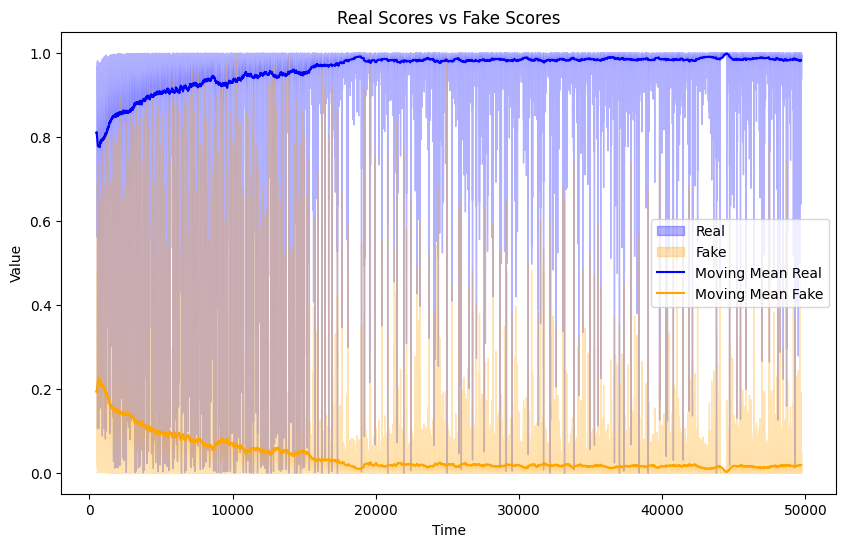

In [32]:
plot_results(real_scores, fake_scores, 'Real Scores vs Fake Scores')

In [33]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Gv2.pth')
torch.save(discriminator.state_dict(), 'Dv2.pth')

In [34]:
import cv2
import os

vid_fname = 'gans_training_v2.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [35]:
from IPython.display import Image

In [36]:
Image('./generated/generated-images-0001.png')

FileNotFoundError: No such file or directory: './generated/generated-images-0001.png'

FileNotFoundError: No such file or directory: './generated/generated-images-0001.png'

<IPython.core.display.Image object>

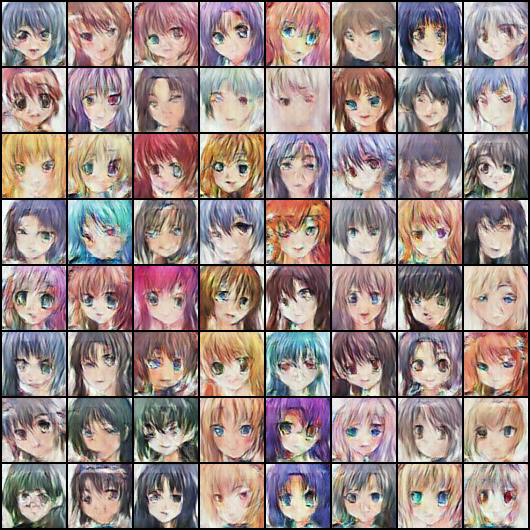

In [37]:
Image('./generated/generated-images-0010.png')

In [38]:
Image('./generated/generated-images-0025.png')

FileNotFoundError: No such file or directory: './generated/generated-images-0025.png'

FileNotFoundError: No such file or directory: './generated/generated-images-0025.png'

<IPython.core.display.Image object>

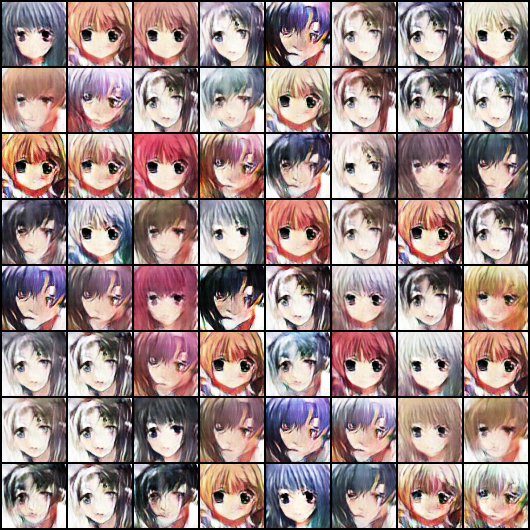

In [39]:
Image('./generated/generated-images-0050.png')

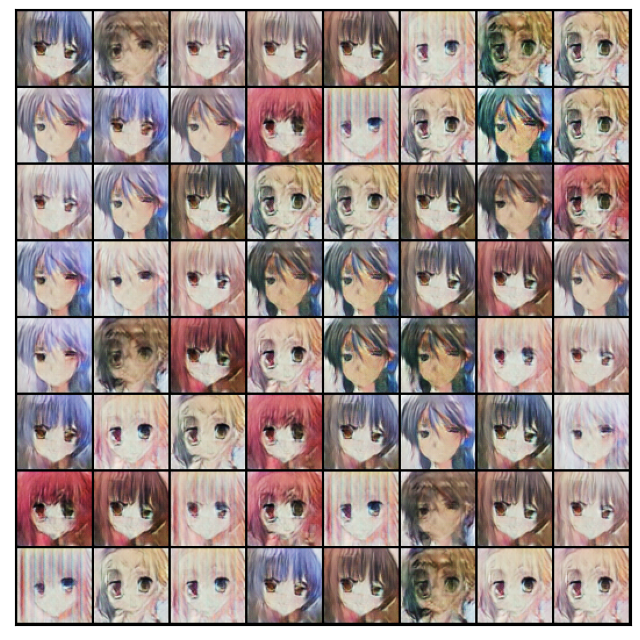

In [40]:
new_latent = torch.randn(64, latent_size, 1, 1, device=device)

fake_images = denorm(generator(new_latent))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))